In [1]:
import nltk, re, pprint
from nltk import word_tokenize
from nltk.corpus import stopwords
from os import listdir
from os.path import isfile, isdir, join
import numpy
import re
import sys
import getopt
import codecs
import time
import os
import csv

chars = ['{','}','#','%','&','\(','\)','\[','\]','<','>',',', '!', '.', ';', 
'?', '*', '\\', '\/', '~', '_','|','=','+','^',':','\"','\'','@','-']

def stem(word):
   regexp = r'^(.*?)(ing|ly|ed|ious|ies|ive|es|s|ment)?$'
   stem, suffix = re.findall(regexp, word)[0]
   return stem

def unique(a):
   """ return the list with duplicate elements removed """
   return list(set(a))

def intersect(a, b):
   """ return the intersection of two lists """
   return list(set(a) & set(b))

def union(a, b):
   """ return the union of two lists """
   return list(set(a) | set(b))

def get_files(mypath):
   return [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]

def get_dirs(mypath):
   return [ f for f in listdir(mypath) if isdir(join(mypath,f)) ]

# Reading a bag of words file back into python. The number and order
# of sentences should be the same as in the *samples_class* file.
def read_bagofwords_dat(myfile):
  bagofwords = numpy.genfromtxt('myfile.csv',delimiter=',')
  return bagofwords

def tokenize_corpus(path, train=True):

  porter = nltk.PorterStemmer() # also lancaster stemmer
  wnl = nltk.WordNetLemmatizer()
  stopWords = stopwords.words("english")
  classes = []
  samples = []
  docs = []
  if train == True:
    words = {}
  f = open(path, 'r')
  lines = f.readlines()

  for line in lines:
    classes.append(line.rsplit()[-1])
    samples.append(line.rsplit()[0])
    raw = line.decode('latin1')
    raw = ' '.join(raw.rsplit()[1:-1])
    # remove noisy characters; tokenize
    raw = re.sub('[%s]' % ''.join(chars), ' ', raw)
    tokens = word_tokenize(raw)
    tokens = [w.lower() for w in tokens]
    tokens = [w for w in tokens if w not in stopWords]
    tokens = [wnl.lemmatize(t) for t in tokens]
    tokens = [porter.stem(t) for t in tokens]   
    if train == True:
     for t in tokens: 
         try:
             words[t] = words[t]+1
         except:
             words[t] = 1
    docs.append(tokens)

  if train == True:
     return(docs, classes, samples, words)
  else:
     return(docs, classes, samples)


def wordcount_filter(words, num=5):
   keepset = []
   for k in words.keys():
       if(words[k] > num):
           keepset.append(k)
   print "Vocab length:", len(keepset)
   return(sorted(set(keepset)))


def find_wordcounts(docs, vocab):
   bagofwords = numpy.zeros(shape=(len(docs),len(vocab)), dtype=numpy.uint8)
   vocabIndex={}
   for i in range(len(vocab)):
      vocabIndex[vocab[i]]=i

   for i in range(len(docs)):
       doc = docs[i]

       for t in doc:
          index_t=vocabIndex.get(t)
          if index_t>=0:
             bagofwords[i,index_t]=1

   print "Finished find_wordcounts for:", len(docs), "docs"
   return(bagofwords)


def main(argv):
  
  start_time = time.time()

  path = ''
  inputf = 'train.txt'
  outputf = 'out'
  vocabf = ''

  try:
   opts, args = getopt.getopt(argv,"p:i:o:v:",["path=","ifile=","ofile=","vocabfile="])
  except getopt.GetoptError:
    print 'Usage: \n python preprocessSentences.py -p <path> -i <inputfile> -o <outputfile> -v <vocabulary>'
    sys.exit(2)
  for opt, arg in opts:
    if opt == '-h':
      print 'Usage: \n python preprocessSentences.py -p <path> -i <inputfile> -o <outputfile> -v <vocabulary>'
      sys.exit()
    elif opt in ("-p", "--path"):
      path = arg
    elif opt in ("-i", "--ifile"):
      inputf = arg
    elif opt in ("-o", "--ofile"):
      outputf = arg
    elif opt in ("-v", "--vocabfile"):
      vocabf = arg

  traintxt = path+"/"+inputf
  print 'Path:', path
  print 'Training data:', traintxt

  # Tokenize training data (if training vocab doesn't already exist):
  if (not vocabf):
    word_count_threshold = 5
    (docs, classes, samples, words) = tokenize_corpus(traintxt, train=True)
    vocab = wordcount_filter(words, num=word_count_threshold)
    # Write new vocab file
    vocabf = outputf+"_vocab_"+str(word_count_threshold)+".txt"
    outfile = codecs.open(path+"/"+vocabf, 'w',"utf-8-sig")
    outfile.write("\n".join(vocab))
    outfile.close()
  else:
    word_count_threshold = 0
    (docs, classes, samples) = tokenize_corpus(traintxt, train=False)
    vocabfile = open(path+"/"+vocabf, 'r')
    vocab = [line.rstrip('\n') for line in vocabfile]
    vocabfile.close()

  print 'Vocabulary file:', path+"/"+vocabf 

  # Get bag of words:
  bow = find_wordcounts(docs, vocab)
  # Check: sum over docs to check if any zero word counts
  print "Doc with smallest number of words in vocab has:", min(numpy.sum(bow, axis=1))

  # Write bow file
  with open(path+"/"+outputf+"_bag_of_words_"+str(word_count_threshold)+"_binary.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerows(bow)

  # Write classes
  outfile = open(path+"/"+outputf+"_classes_"+str(word_count_threshold)+".txt", 'w')
  outfile.write("\n".join(classes))
  outfile.close()

  # Write samples
  outfile = open(path+"/"+outputf+"_samples_class_"+str(word_count_threshold)+".txt", 'w')
  outfile.write("\n".join(samples))
  outfile.close()

  print 'Output files:', path+"/"+outputf+"*"

  # Runtime
  print 'Runtime:', str(time.time() - start_time)

argv1 = "./preprocessSentencesBinary.py -p . -i train.txt -o train".split()
argv2 = "./preprocessSentencesBinary.py -p . -i test.txt -o test -v train_vocab_5.txt".split()

print argv1[1:]

main(argv1[1:])
main(argv2[1:])

 


['-p', '.', '-i', 'train.txt', '-o', 'train']
Path: .
Training data: ./train.txt
Vocab length: 541
Vocabulary file: ./train_vocab_5.txt
Finished find_wordcounts for: 2400 docs
Doc with smallest number of words in vocab has: 0
Output files: ./train*
Runtime: 4.04540085793
Path: .
Training data: ./test.txt
Vocabulary file: ./train_vocab_5.txt
Finished find_wordcounts for: 600 docs
Doc with smallest number of words in vocab has: 0
Output files: ./test*
Runtime: 0.433381080627


In [2]:
import sklearn
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics
import numpy
import random
import matplotlib.pyplot as plt

''' Logistic Regression (Binary) '''
# class labels
y_train = numpy.genfromtxt('train_classes_5.txt', delimiter = '\n')
y_test = numpy.genfromtxt('test_classes_0.txt', delimiter = '\n')

# binary bag of words
x_train = numpy.genfromtxt('train_bag_of_words_5_binary.csv', delimiter=',')
x_test = numpy.genfromtxt('test_bag_of_words_0_binary.csv', delimiter=',')

from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(x_train, y_train)
y_pred = model.predict(x_test)

print "\n"
print "Logistic Regression accuracy: ", metrics.accuracy_score(y_test, y_pred)
conf_mat = metrics.confusion_matrix(y_test, y_pred)
tp = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tn = conf_mat[1][1]
precision = float(tp)/(tp+fp)
recall = float(tp)/(tp+fn)
specificity = float(tn)/(fp+tn)
print "Confusion Matrix:\n", conf_mat
print "Precision: ", precision
print "Recall: ", recall
print "Specificity: ", specificity
print "False Positive Rate: ", 1-specificity
print "F1 score: ", 2*precision*recall/(precision+recall)

y_probs = model.predict_proba(x_test)
y_p = map(lambda z: z[1], y_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()
n = len(y_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_p)
roc_auc = metrics.auc(fpr, tpr)

print "AUC: ", roc_auc

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()




Logistic Regression accuracy:  0.81
Confusion Matrix:
[[263  37]
 [ 77 223]]
Precision:  0.876666666667
Recall:  0.773529411765
Specificity:  0.857692307692
False Positive Rate:  0.142307692308
F1 score:  0.821875
AUC:  0.879738888888889


In [3]:
vocab = []
with open("train_vocab_5.txt", "rb") as vfile:
    lines = vfile.readlines()
    for line in lines:
        vocab.append(line.strip())


embeddings = dict()
with open("glove.twitter.27B.200d.txt", "rb") as efile:
    lines = efile.readlines()
    for line in lines:
        word = line.split()[0]
        vector = line.split()[1:]
        vector = map(lambda z: float(z), vector)
        embeddings[word] = vector

In [4]:
print len(vocab), len(embeddings)

541 1193514




Logistic Regression + GloVe accuracy:  0.785
Confusion Matrix:
[[248  52]
 [ 77 223]]
Precision:  0.826666666667
Recall:  0.763076923077
Specificity:  0.810909090909
False Positive Rate:  0.189090909091
F1 score:  0.7936
AUC:  0.8537499999999999


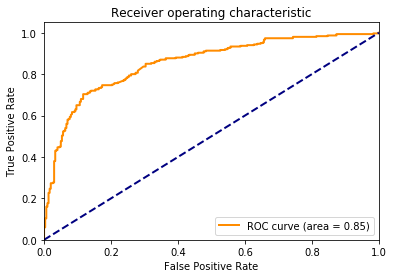

In [5]:
import numpy as np

def convertToVector(start):
    output = np.zeros(200)
    for i in range(len(start)):
        if (start[i] > 0 and (embeddings.get(vocab[i]) != None)):
            output = np.add(output, embeddings.get(vocab[i]))
    return output



# class labels
y_train = numpy.genfromtxt('train_classes_5.txt', delimiter = '\n')
y_test = numpy.genfromtxt('test_classes_0.txt', delimiter = '\n')

# frequency bag of words
x_train = numpy.genfromtxt('train_bag_of_words_5_binary.csv', delimiter=',')
x_test = numpy.genfromtxt('test_bag_of_words_0_binary.csv', delimiter=',')

x_train = map(lambda z: convertToVector(z), x_train)
x_test = map(lambda z: convertToVector(z), x_test)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(x_train, y_train)

y_pred = model.predict(x_test)

print "\n"
print "Logistic Regression + GloVe accuracy: ", metrics.accuracy_score(y_test, y_pred)
conf_mat = metrics.confusion_matrix(y_test, y_pred)
tp = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tn = conf_mat[1][1]
precision = float(tp)/(tp+fp)
recall = float(tp)/(tp+fn)
specificity = float(tn)/(fp+tn)
print "Confusion Matrix:\n", conf_mat
print "Precision: ", precision
print "Recall: ", recall
print "Specificity: ", specificity
print "False Positive Rate: ", 1-specificity
print "F1 score: ", 2*precision*recall/(precision+recall)

y_probs = model.predict_proba(x_test)
y_p = map(lambda z: z[1], y_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()
n = len(y_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_p)
roc_auc = metrics.auc(fpr, tpr)

print "AUC: ", roc_auc

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

        
        

In [6]:
#BIGRAM PROCESS

import nltk, re, pprint
from nltk import word_tokenize
from nltk.corpus import stopwords
from os import listdir
from os.path import isfile, isdir, join
import numpy
import re
import sys
import getopt
import codecs
import time
import os
import csv

chars = ['{','}','#','%','&','\(','\)','\[','\]','<','>',',', '!', '.', ';', 
'?', '*', '\\', '\/', '~', '_','|','=','+','^',':','\"','\'','@','-']

def stem(word):
   regexp = r'^(.*?)(ing|ly|ed|ious|ies|ive|es|s|ment)?$'
   stem, suffix = re.findall(regexp, word)[0]
   return stem

def unique(a):
   """ return the list with duplicate elements removed """
   return list(set(a))

def intersect(a, b):
   """ return the intersection of two lists """
   return list(set(a) & set(b))

def union(a, b):
   """ return the union of two lists """
   return list(set(a) | set(b))

def get_files(mypath):
   return [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]

def get_dirs(mypath):
   return [ f for f in listdir(mypath) if isdir(join(mypath,f)) ]

# Reading a bag of words file back into python. The number and order
# of sentences should be the same as in the *samples_class* file.
def read_bagofwords_dat(myfile):
  bagofwords = numpy.genfromtxt('myfile.csv',delimiter=',')
  return bagofwords

def tokenize_corpus(path, train=True):

  porter = nltk.PorterStemmer() # also lancaster stemmer
  wnl = nltk.WordNetLemmatizer()
  stopWords = stopwords.words("english")
  classes = []
  samples = []
  docs = []
  if train == True:
    words = {}
  f = open(path, 'r')
  lines = f.readlines()

  for line in lines:
    classes.append(line.rsplit()[-1])
    samples.append(line.rsplit()[0])
    raw = line.decode('latin1')
    raw = ' '.join(raw.rsplit()[1:-1])
    # remove noisy characters; tokenize
    raw = re.sub('[%s]' % ''.join(chars), ' ', raw)
    tokens = word_tokenize(raw)
    tokens = [w.lower() for w in tokens]
    tokens = [w for w in tokens if w not in stopWords]
    tokens = [wnl.lemmatize(t) for t in tokens]
    tokens = [porter.stem(t) for t in tokens]   
    if train == True:
        for i in range(len(tokens) - 1): 
            t = tokens[i]
            t2 = tokens[i+1]
            both = t + ";" + t2
            try:
                 words[both] = words[both]+1
            except:
                 words[both] = 1
    docs.append(tokens)

  if train == True:
     return(docs, classes, samples, words)
  else:
     return(docs, classes, samples)


def wordcount_filter(words, num=5):
   keepset = []
   for k in words.keys():
       if(words[k] > num):
           keepset.append(k)
   print "Vocab length:", len(keepset)
   return(sorted(set(keepset)))


def find_wordcounts(docs, vocab):
   bagofwords = numpy.zeros(shape=(len(docs),len(vocab)), dtype=numpy.uint8)
   vocabIndex={}
   for i in range(len(vocab)):
      vocabIndex[vocab[i]]=i

   for i in range(len(docs)):
       doc = docs[i]

       for j in range(len(doc) - 1):
          t = doc[j]
          t2 = doc[j+1]
          both = t + ";" + t2
          index_t=vocabIndex.get(both)
          if index_t>=0:
             bagofwords[i,index_t]=1

   print "Finished find_wordcounts for:", len(docs), "docs"
   return(bagofwords)


def main(argv):
  
  start_time = time.time()

  path = ''
  inputf = 'train.txt'
  outputf = 'out'
  vocabf = ''

  try:
   opts, args = getopt.getopt(argv,"p:i:o:v:",["path=","ifile=","ofile=","vocabfile="])
  except getopt.GetoptError:
    print 'Usage: \n python preprocessSentences.py -p <path> -i <inputfile> -o <outputfile> -v <vocabulary>'
    sys.exit(2)
  for opt, arg in opts:
    if opt == '-h':
      print 'Usage: \n python preprocessSentences.py -p <path> -i <inputfile> -o <outputfile> -v <vocabulary>'
      sys.exit()
    elif opt in ("-p", "--path"):
      path = arg
    elif opt in ("-i", "--ifile"):
      inputf = arg
    elif opt in ("-o", "--ofile"):
      outputf = arg
    elif opt in ("-v", "--vocabfile"):
      vocabf = arg

  traintxt = path+"/"+inputf
  print 'Path:', path
  print 'Training data:', traintxt

  # Tokenize training data (if training vocab doesn't already exist):
  if (not vocabf):
    word_count_threshold = 2
    (docs, classes, samples, words) = tokenize_corpus(traintxt, train=True)
    vocab = wordcount_filter(words, num=word_count_threshold)
    # Write new vocab file
    vocabf = outputf+"_vocab_"+str(word_count_threshold)+".txt"
    outfile = codecs.open(path+"/"+vocabf, 'w',"utf-8-sig")
    outfile.write("\n".join(vocab))
    outfile.close()
  else:
    word_count_threshold = 0
    (docs, classes, samples) = tokenize_corpus(traintxt, train=False)
    vocabfile = open(path+"/"+vocabf, 'r')
    vocab = [line.rstrip('\n') for line in vocabfile]
    vocabfile.close()

  print 'Vocabulary file:', path+"/"+vocabf 

  # Get bag of words:
  bow = find_wordcounts(docs, vocab)
  # Check: sum over docs to check if any zero word counts
  print "Doc with smallest number of words in vocab has:", min(numpy.sum(bow, axis=1))

  # Write bow file
  with open(path+"/"+outputf+"_bag_of_words_"+str(word_count_threshold)+"_bigram.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerows(bow)

  # Write classes
  outfile = open(path+"/"+outputf+"_classes_"+str(word_count_threshold)+".txt", 'w')
  outfile.write("\n".join(classes))
  outfile.close()

  # Write samples
  outfile = open(path+"/"+outputf+"_samples_class_"+str(word_count_threshold)+".txt", 'w')
  outfile.write("\n".join(samples))
  outfile.close()

  print 'Output files:', path+"/"+outputf+"*"

  # Runtime
  print 'Runtime:', str(time.time() - start_time)

argv1 = "./preprocessBigram.py -p . -i train.txt -o train".split()
argv2 = "./preprocessBigram.py -p . -i test.txt -o test -v train_vocab_2.txt".split()

print argv1[1:]

main(argv1[1:])
main(argv2[1:])
 



['-p', '.', '-i', 'train.txt', '-o', 'train']
Path: .
Training data: ./train.txt
Vocab length: 198
Vocabulary file: ./train_vocab_2.txt
Finished find_wordcounts for: 2400 docs
Doc with smallest number of words in vocab has: 0
Output files: ./train*
Runtime: 1.58593893051
Path: .
Training data: ./test.txt
Vocabulary file: ./train_vocab_2.txt
Finished find_wordcounts for: 600 docs
Doc with smallest number of words in vocab has: 0
Output files: ./test*
Runtime: 0.372950077057


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.

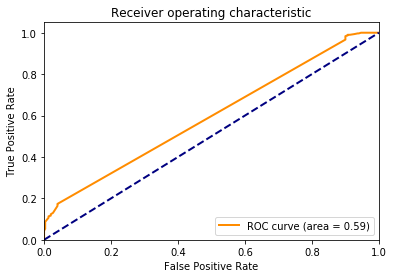

0.565

In [7]:
import sklearn
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics
import numpy
import random
import matplotlib.pyplot as plt

''' Multinomial '''

# class labels
y_train = numpy.genfromtxt('train_classes_2.txt', delimiter = '\n')
y_test = numpy.genfromtxt('test_classes_0.txt', delimiter = '\n')

# frequency bag of words
x_train = numpy.genfromtxt('train_bag_of_words_2_bigram.csv', delimiter=',')
x_test = numpy.genfromtxt('test_bag_of_words_0_bigram.csv', delimiter=',')

# fit Multinomial NB classifier
model = MultinomialNB().fit(x_train, y_train)
y_pred = model.predict(x_test)
print y_pred
print "Multinomial NB accuracy: ", metrics.accuracy_score(y_test, y_pred)
conf_mat = metrics.confusion_matrix(y_test, y_pred)
tp = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tn = conf_mat[1][1]
print conf_mat
precision = float(tp)/(tp+fp)
recall = float(tp)/(tp+fn)
specificity = float(tn)/(fp+tn)
print "Confusion Matrix:\n", conf_mat
print "Precision: ", precision
print "Recall: ", recall
print "Specificity: ", specificity
print "False Positive Rate: ", 1-specificity
print "F1 score: ", 2*precision*recall/(precision+recall)

y_probs = model.predict_proba(x_test)
y_p = map(lambda z: z[1], y_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()
n = len(y_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_p)
roc_auc = metrics.auc(fpr, tpr)

print "AUC: ", roc_auc


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()





from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(x_train, y_train)
model.score(x_test, y_test)


In [8]:
#PREPROCESS BOTH
import nltk, re, pprint
from nltk import word_tokenize
from nltk.corpus import stopwords
from os import listdir
from os.path import isfile, isdir, join
import numpy
import re
import sys
import getopt
import codecs
import time
import os
import csv

chars = ['{','}','#','%','&','\(','\)','\[','\]','<','>',',', '!', '.', ';', 
'?', '*', '\\', '\/', '~', '_','|','=','+','^',':','\"','\'','@','-']

def stem(word):
   regexp = r'^(.*?)(ing|ly|ed|ious|ies|ive|es|s|ment)?$'
   stem, suffix = re.findall(regexp, word)[0]
   return stem

def unique(a):
   """ return the list with duplicate elements removed """
   return list(set(a))

def intersect(a, b):
   """ return the intersection of two lists """
   return list(set(a) & set(b))

def union(a, b):
   """ return the union of two lists """
   return list(set(a) | set(b))

def get_files(mypath):
   return [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]

def get_dirs(mypath):
   return [ f for f in listdir(mypath) if isdir(join(mypath,f)) ]

# Reading a bag of words file back into python. The number and order
# of sentences should be the same as in the *samples_class* file.
def read_bagofwords_dat(myfile):
  bagofwords = numpy.genfromtxt('myfile.csv',delimiter=',')
  return bagofwords

def tokenize_corpus(path, train=True):

  porter = nltk.PorterStemmer() # also lancaster stemmer
  wnl = nltk.WordNetLemmatizer()
  stopWords = stopwords.words("english")
  classes = []
  samples = []
  docs = []
  if train == True:
    words = {}
  f = open(path, 'r')
  lines = f.readlines()

  for line in lines:
    classes.append(line.rsplit()[-1])
    samples.append(line.rsplit()[0])
    raw = line.decode('latin1')
    raw = ' '.join(raw.rsplit()[1:-1])
    # remove noisy characters; tokenize
    raw = re.sub('[%s]' % ''.join(chars), ' ', raw)
    tokens = word_tokenize(raw)
    tokens = [w.lower() for w in tokens]
    tokens = [w for w in tokens if w not in stopWords]
    tokens = [wnl.lemmatize(t) for t in tokens]
    tokens = [porter.stem(t) for t in tokens]   
    if train == True:
        for i in range(len(tokens) - 1): 
            t = tokens[i]
            t2 = tokens[i+1]
            both = t + ";" + t2
            try:
                 words[both] = words[both]+1
            except:
                 words[both] = 1
            try:
                 words[t] = words[t]+1
            except:
                 words[t] = 1
    docs.append(tokens)

  if train == True:
     return(docs, classes, samples, words)
  else:
     return(docs, classes, samples)


def wordcount_filter(words, num=5):
   keepset = []
   for k in words.keys():
       if(words[k] > num):
           keepset.append(k)
   print "Vocab length:", len(keepset)
   return(sorted(set(keepset)))


def find_wordcounts(docs, vocab):
    bagofwords = numpy.zeros(shape=(len(docs),len(vocab)), dtype=numpy.uint8)
    vocabIndex={}
    for i in range(len(vocab)):
        vocabIndex[vocab[i]]=i

    for i in range(len(docs)):
        doc = docs[i]

        for j in range(len(doc) - 1):
            t = doc[j]
            t2 = doc[j+1]
            both = t + ";" + t2
            index_t=vocabIndex.get(both)
            if index_t>=0:
                bagofwords[i,index_t]=1
            index_t=vocabIndex.get(t)
            if index_t>=0:
                bagofwords[i,index_t]=1
          
            index_t=vocabIndex.get(t2)
            if index_t>=0:
                bagofwords[i,index_t]=1

    print "Finished find_wordcounts for:", len(docs), "docs"
    return(bagofwords)


def main(argv):
  
  start_time = time.time()

  path = ''
  inputf = 'train.txt'
  outputf = 'out'
  vocabf = ''

  try:
   opts, args = getopt.getopt(argv,"p:i:o:v:",["path=","ifile=","ofile=","vocabfile="])
  except getopt.GetoptError:
    print 'Usage: \n python preprocessSentences.py -p <path> -i <inputfile> -o <outputfile> -v <vocabulary>'
    sys.exit(2)
  for opt, arg in opts:
    if opt == '-h':
      print 'Usage: \n python preprocessSentences.py -p <path> -i <inputfile> -o <outputfile> -v <vocabulary>'
      sys.exit()
    elif opt in ("-p", "--path"):
      path = arg
    elif opt in ("-i", "--ifile"):
      inputf = arg
    elif opt in ("-o", "--ofile"):
      outputf = arg
    elif opt in ("-v", "--vocabfile"):
      vocabf = arg

  traintxt = path+"/"+inputf
  print 'Path:', path
  print 'Training data:', traintxt

  # Tokenize training data (if training vocab doesn't already exist):
  if (not vocabf):
    word_count_threshold = 2
    (docs, classes, samples, words) = tokenize_corpus(traintxt, train=True)
    vocab = wordcount_filter(words, num=word_count_threshold)
    # Write new vocab file
    vocabf = outputf+"_vocab_"+str(word_count_threshold)+".txt"
    outfile = codecs.open(path+"/"+vocabf, 'w',"utf-8-sig")
    outfile.write("\n".join(vocab))
    outfile.close()
  else:
    word_count_threshold = 0
    (docs, classes, samples) = tokenize_corpus(traintxt, train=False)
    vocabfile = open(path+"/"+vocabf, 'r')
    vocab = [line.rstrip('\n') for line in vocabfile]
    vocabfile.close()

  print 'Vocabulary file:', path+"/"+vocabf 

  # Get bag of words:
  bow = find_wordcounts(docs, vocab)
  # Check: sum over docs to check if any zero word counts
  print "Doc with smallest number of words in vocab has:", min(numpy.sum(bow, axis=1))

  # Write bow file
  with open(path+"/"+outputf+"_bag_of_words_"+str(word_count_threshold)+"_both.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerows(bow)

  # Write classes
  outfile = open(path+"/"+outputf+"_classes_"+str(word_count_threshold)+".txt", 'w')
  outfile.write("\n".join(classes))
  outfile.close()

  # Write samples
  outfile = open(path+"/"+outputf+"_samples_class_"+str(word_count_threshold)+".txt", 'w')
  outfile.write("\n".join(samples))
  outfile.close()

  print 'Output files:', path+"/"+outputf+"*"

  # Runtime
  print 'Runtime:', str(time.time() - start_time)


argv1 = "./preprocessBoth.py -p . -i train.txt -o train".split()
argv2 = "./preprocessBoth.py -p . -i test.txt -o test -v train_vocab_2.txt".split()

print argv1[1:]

main(argv1[1:])
main(argv2[1:])

 


['-p', '.', '-i', 'train.txt', '-o', 'train']
Path: .
Training data: ./train.txt
Vocab length: 1140
Vocabulary file: ./train_vocab_2.txt
Finished find_wordcounts for: 2400 docs
Doc with smallest number of words in vocab has: 0
Output files: ./train*
Runtime: 2.45095396042
Path: .
Training data: ./test.txt
Vocabulary file: ./train_vocab_2.txt
Finished find_wordcounts for: 600 docs
Doc with smallest number of words in vocab has: 0
Output files: ./test*
Runtime: 0.626814126968




Bernoulli NB accuracy:  0.78
Confusion Matrix:
[[247  53]
 [ 79 221]]
Precision:  0.823333333333
Recall:  0.757668711656
Specificity:  0.806569343066
False Positive Rate:  0.193430656934
F1 score:  0.789137380192
AUC:  0.8660888888888889
5.0


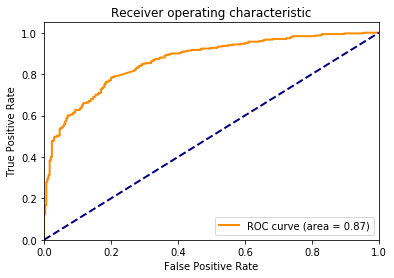



Bernoulli NB accuracy:  0.8033333333333333
Confusion Matrix:
[[259  41]
 [ 77 223]]
Precision:  0.863333333333
Recall:  0.770833333333
Specificity:  0.844696969697
False Positive Rate:  0.155303030303
F1 score:  0.814465408805
AUC:  0.8787000000000001
5.0


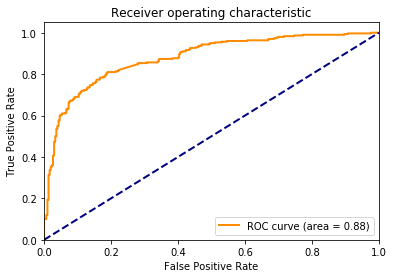

In [9]:
import sklearn
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics
import numpy
import random
#import matplotlib.pyplot as plt

''' Multinomial '''

# class labels
y_train = numpy.genfromtxt('train_classes_2.txt', delimiter = '\n')
y_test = numpy.genfromtxt('test_classes_0.txt', delimiter = '\n')

# frequency bag of words
x_train = numpy.genfromtxt('train_bag_of_words_2_both.csv', delimiter=',')
x_test = numpy.genfromtxt('test_bag_of_words_0_both.csv', delimiter=',')

# fit Bernoulli Naive Bayes classifier
model = BernoulliNB().fit(x_train, y_train)
y_pred = model.predict(x_test)

print "\n"
print "Bernoulli NB accuracy: ", metrics.accuracy_score(y_test, y_pred)
conf_mat = metrics.confusion_matrix(y_test, y_pred)
tp = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tn = conf_mat[1][1]
precision = float(tp)/(tp+fp)
recall = float(tp)/(tp+fn)
specificity = float(tn)/(fp+tn)
print "Confusion Matrix:\n", conf_mat
print "Precision: ", precision
print "Recall: ", recall
print "Specificity: ", specificity
print "False Positive Rate: ", 1-specificity
print "F1 score: ", 2*precision*recall/(precision+recall)

y_probs = model.predict_proba(x_test)
y_p = map(lambda z: z[1], y_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()
n = len(y_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_p)
roc_auc = metrics.auc(fpr, tpr)

print "AUC: ", roc_auc
print sum(x_train[0])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()




from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(x_train, y_train)

y_pred = model.predict(x_test)

print "\n"
print "Bernoulli NB accuracy: ", metrics.accuracy_score(y_test, y_pred)
conf_mat = metrics.confusion_matrix(y_test, y_pred)
tp = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tn = conf_mat[1][1]
precision = float(tp)/(tp+fp)
recall = float(tp)/(tp+fn)
specificity = float(tn)/(fp+tn)
print "Confusion Matrix:\n", conf_mat
print "Precision: ", precision
print "Recall: ", recall
print "Specificity: ", specificity
print "False Positive Rate: ", 1-specificity
print "F1 score: ", 2*precision*recall/(precision+recall)

y_probs = model.predict_proba(x_test)
y_p = map(lambda z: z[1], y_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()
n = len(y_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_p)
roc_auc = metrics.auc(fpr, tpr)

print "AUC: ", roc_auc
print sum(x_train[0])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()